In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
# Plots
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:

df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [3]:
df_X_train = df_train.drop(labels=["label"], axis=1)
df_y_train = df_train["label"]
del df_train

In [4]:
label_counts = df_y_train.value_counts().sort_index()
num_labels = label_counts.shape[0]

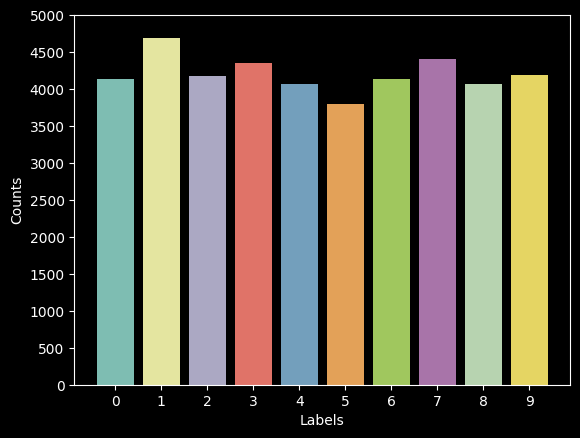

In [5]:
mpl.style.use('dark_background')
# mpl.rcParams.update({'font.size': 16, 'text.usetex': True})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:num_labels]
fig, ax = plt.subplots()

bar_labels = [str(x) for x in range(0, 10)]
bar_counts = [x for x in label_counts]

ax.bar(bar_labels, bar_counts, label=bar_labels, color=colors, alpha=0.9)
ax.set_xlabel('Labels')
ax.set_ylabel('Counts')
ax.set_yticks(np.arange(0,5500, 500))
plt.show()

In [6]:
# use validation size of 10% of the training dataset
validation_size = 0.1
X_train, y_train = df_X_train.to_numpy(), df_y_train.to_numpy()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=validation_size, shuffle=True, random_state=1, stratify=y_train)

In [7]:
print(f"Training:\t{X_train.shape[0]}")
print(f"Validation:\t{X_valid.shape[0]}")

Training:	37800
Validation:	4200


In [8]:
first_images = X_train[:100].reshape((-1,28,28)).astype(np.uint8)
first_images_labels = y_train[:100].astype(np.uint8)

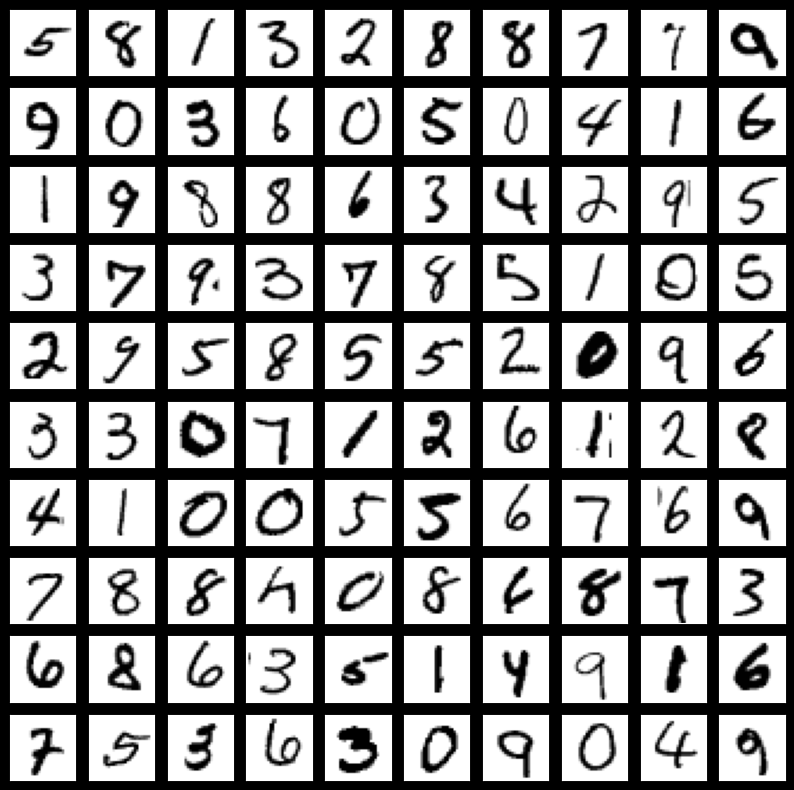

In [9]:
mpl.style.use('dark_background')
fig = plt.figure(figsize=(10,10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    img = first_images[i]
    ax.imshow(img, cmap='gray_r')
plt.show()

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(f'Using device: {device}')

Using device: cuda


In [11]:
torch.set_default_device(device)
torch.manual_seed(0)

In [12]:
# Reshape input
X_train, y_train = X_train.reshape(
    (-1, 1, 28, 28)).astype(np.float32), y_train.astype(np.uint8)
X_valid, y_valid = X_valid.reshape(
    (-1, 1, 28, 28)).astype(np.float32), y_valid.astype(np.uint8)

In [13]:
print(f"X_train: {X_train.shape}\nX_valid: {X_valid.shape}")

X_train: (37800, 1, 28, 28)
X_valid: (4200, 1, 28, 28)


In [14]:
# Transform to PyTorch Tensor
X_train, y_train = torch.from_numpy(X_train), torch.from_numpy(y_train)
X_valid, y_valid = torch.from_numpy(X_valid), torch.from_numpy(y_valid)
print(f"X_train: {X_train.shape}\nX_valid: {X_valid.shape}")

X_train: torch.Size([37800, 1, 28, 28])
X_valid: torch.Size([4200, 1, 28, 28])


In [15]:
from enum import Enum

num_augments = 10


class DatasetType(Enum):
    TRAIN = 0,
    VALID = 1,
    TEST = 2


class MNIST_data(Dataset):
    def __init__(self, X, y=None, set_type=DatasetType.TRAIN, device=None):
        normalize = v2.Normalize(mean=(0.5,), std=(0.5,))
        randomAffine = v2.RandomAffine(degrees=(-45, 45), translate=(0.1, 0.1))

        X = X.to(device)
        X = normalize(X)
        if set_type is DatasetType.TRAIN:
            X_aug = torch.empty(size=(len(X) * (num_augments), 1, 28, 28))
            count = 0
            for idx_aug in range(num_augments):
                print(f"Augment {idx_aug + 1}")
                for idx in range(len(X)):
                    X_aug[count] = randomAffine(X[idx])
                    count += 1
            self.X = torch.vstack((X, X_aug)).to(device)
            self.y = y.repeat(num_augments + 1).to(device)

        else:
            self.X = X.to(device)
            if y is not None:
                self.y = y.to(device)

        print('', end='\r')

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [16]:
!pip install --upgrade torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [16]:
train_ds = MNIST_data(X_train, y_train, DatasetType.TRAIN, device = device)
valid_ds = MNIST_data(X_valid, y_valid, DatasetType.VALID, device = device)

Augment 1
Augment 2
Augment 3
Augment 4
Augment 5
Augment 6
Augment 7
Augment 8
Augment 9
Augment 10


In [17]:
batch_size = 64
generator = torch.Generator(device)
train_dl = DataLoader(train_ds, batch_size, shuffle=True, generator = generator)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, generator = generator)

In [18]:
print(f"Augmented train size: {len(train_dl.dataset)}")

Augmented train size: 415800


In [29]:
import torch
import torch.nn as nn

# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)  # Example layer: from 784 input features to 128 output features
        self.fc2 = nn.Linear(128, 10)   # Another layer: from 128 to 10 output features

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = Net()

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)




In [31]:
import torch
from torch.utils.data import DataLoader

# Dummy DataLoader for demonstration
train_loader = DataLoader(torch.rand(100, 10), batch_size=10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Processing loop
for x_batch in train_loader:
    x_batch = x_batch.to(device)  # Move to device
    # Assuming y_batch is similarly defined somewhere before this
    y_batch = torch.randint(0, 2, (10,)).to(device).long()  # Dummy target tensor for demonstration

    # Further processing like passing x_batch, y_batch through a model



In [32]:
print(f"Input batch data: {x_batch}")
print(f"Min value in batch: {x_batch.min()}")
print(f"Max value in batch: {x_batch.max()}")


Input batch data: tensor([[0.3419, 0.9263, 0.0753, 0.3338, 0.8464, 0.0902, 0.6249, 0.7778, 0.1453,
         0.7891],
        [0.2371, 0.3805, 0.8375, 0.9662, 0.8603, 0.0666, 0.7070, 0.8682, 0.8959,
         0.3416],
        [0.2153, 0.3401, 0.0109, 0.0831, 0.7562, 0.5773, 0.4840, 0.4491, 0.7390,
         0.7633],
        [0.1806, 0.3952, 0.2460, 0.1014, 0.8789, 0.2511, 0.0662, 0.4865, 0.2442,
         0.7710],
        [0.9118, 0.6302, 0.0665, 0.7125, 0.6057, 0.6778, 0.5346, 0.0897, 0.0541,
         0.0814],
        [0.8457, 0.4024, 0.9793, 0.9479, 0.5496, 0.7135, 0.4886, 0.5930, 0.4937,
         0.5719],
        [0.6287, 0.1593, 0.1428, 0.5776, 0.6174, 0.9394, 0.7767, 0.2185, 0.2223,
         0.6417],
        [0.6023, 0.8772, 0.7715, 0.4435, 0.8136, 0.7595, 0.3024, 0.9701, 0.6254,
         0.1175],
        [0.8476, 0.2438, 0.9544, 0.3669, 0.8524, 0.1941, 0.4983, 0.5690, 0.0875,
         0.3761],
        [0.9083, 0.0967, 0.5083, 0.3168, 0.8943, 0.6883, 0.2333, 0.8579, 0.8373,
         0

In [33]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


tensor(0., device='cuda:0')

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Reduce learning rate


In [37]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)

model.apply(init_weights)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [38]:
# Instead of BatchNorm2d
bn1 = nn.GroupNorm(32, 32)

In [39]:
x_batch = x_batch / 255.0  # If max value is 255


In [41]:
# Example check right before feeding into the model
print("Shape of x_batch before model:", x_batch.shape)

# Assuming x_batch should be (batch_size, 784) and it's currently (batch_size, 28, 28)
# Flatten x_batch if it's an image input that needs to be flattened
x_batch = x_batch.view(x_batch.size(0), -1)  # This reshapes it to (batch_size, 784)

# Feed into the model
pred = model(x_batch)


Shape of x_batch before model: torch.Size([64, 1, 28, 28])


In [42]:
for epoch in range(num_epochs):
    for i, (x_batch, y_batch) in enumerate(train_dl):
        # Move batches to the device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device).long()

        # Flatten the x_batch from [64, 1, 28, 28] to [64, 784]
        x_batch = x_batch.view(x_batch.size(0), -1)  # Flatten each image in the batch

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing x_batch to the model
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)

        # Check for NaN or Infinite values in loss
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN or Inf detected in loss at epoch {epoch+1}, batch {i+1}")
            break  # Stop training this batch

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        optimizer.step()


In [43]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)  # First layer takes 784 inputs
        # Add more layers as necessary

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # Add more operations as necessary
        return x


In [44]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


tensor(57.7547, device='cuda:0')

In [45]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)

model.apply(init_weights)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [48]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    acc_hist_train = [0] * num_epochs
    acc_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train(True)
        for x_batch, y_batch in train_dl:
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()

            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            acc_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        acc_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                acc_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            acc_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f"Epoch {epoch+1}\n\tAccuracy:\n\t\ttrain: {acc_hist_train[epoch]:.4f} valid: {acc_hist_valid[epoch]:.4f}\n\tLoss:\n\t\ttrain: {loss_hist_train[epoch]:.4f} valid: {loss_hist_valid[epoch]:.4f}")
    return loss_hist_train, loss_hist_valid, acc_hist_train, acc_hist_valid

In [50]:
x = torch.ones((128, 1, 28, 28))

In [52]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (bn3): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [53]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    acc_hist_train = [0] * num_epochs
    acc_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train(True)
        for x_batch, y_batch in train_dl:
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()

            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            acc_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        acc_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                acc_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            acc_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f"Epoch {epoch+1}\n\tAccuracy:\n\t\ttrain: {acc_hist_train[epoch]:.4f} valid: {acc_hist_valid[epoch]:.4f}\n\tLoss:\n\t\ttrain: {loss_hist_train[epoch]:.4f} valid: {loss_hist_valid[epoch]:.4f}")
    return loss_hist_train, loss_hist_valid, acc_hist_train, acc_hist_valid

In [54]:
num_epochs = 25
loss_hist_train, loss_hist_valid, acc_hist_train, acc_hist_valid = train(model, num_epochs, train_dl, valid_dl)

Epoch 1
	Accuracy:
		train: 0.9612 valid: 0.9833
	Loss:
		train: 0.1309 valid: 0.0687
Epoch 2
	Accuracy:
		train: 0.9818 valid: 0.9893
	Loss:
		train: 0.0633 valid: 0.0431
Epoch 3
	Accuracy:
		train: 0.9862 valid: 0.9912
	Loss:
		train: 0.0478 valid: 0.0340
Epoch 4
	Accuracy:
		train: 0.9891 valid: 0.9893
	Loss:
		train: 0.0391 valid: 0.0451
Epoch 5
	Accuracy:
		train: 0.9906 valid: 0.9914
	Loss:
		train: 0.0343 valid: 0.0355
Epoch 6
	Accuracy:
		train: 0.9916 valid: 0.9907
	Loss:
		train: 0.0305 valid: 0.0575
Epoch 7
	Accuracy:
		train: 0.9925 valid: 0.9921
	Loss:
		train: 0.0278 valid: 0.0625
Epoch 8
	Accuracy:
		train: 0.9933 valid: 0.9929
	Loss:
		train: 0.0254 valid: 0.0410
Epoch 9
	Accuracy:
		train: 0.9938 valid: 0.9902
	Loss:
		train: 0.0242 valid: 0.0532
Epoch 10
	Accuracy:
		train: 0.9940 valid: 0.9936
	Loss:
		train: 0.0220 valid: 0.0465
Epoch 11
	Accuracy:
		train: 0.9948 valid: 0.9914
	Loss:
		train: 0.0205 valid: 0.0629
Epoch 12
	Accuracy:
		train: 0.9949 valid: 0.9917
	L

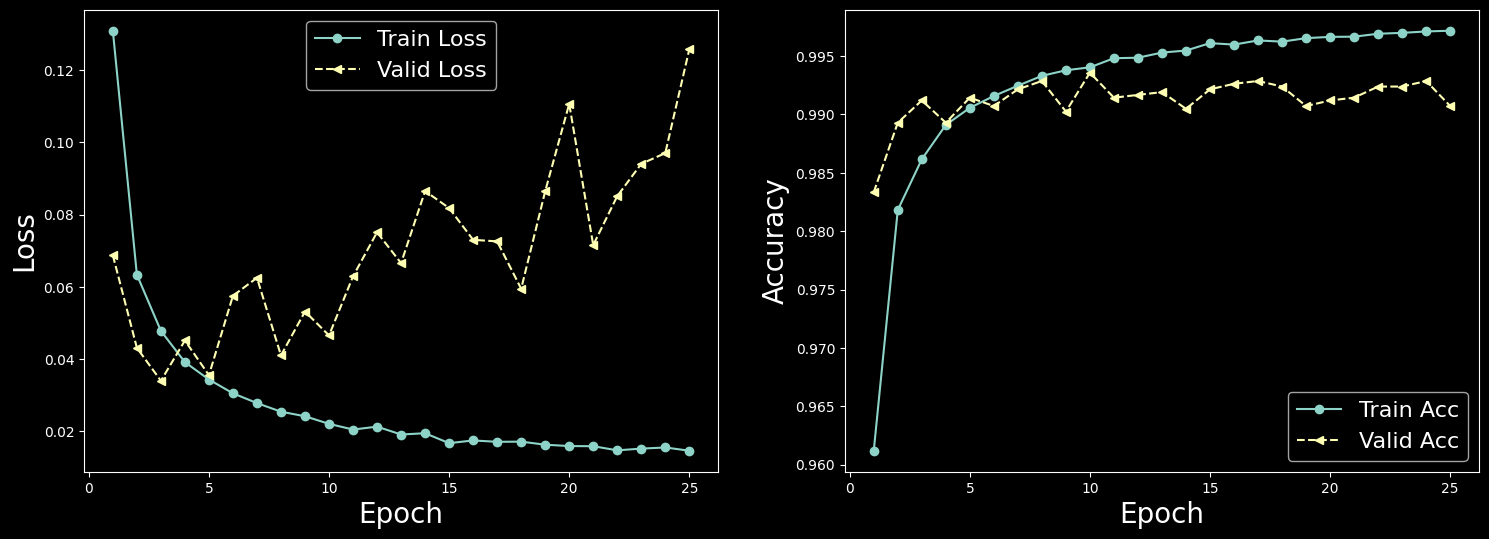

In [56]:
x_arr = np.arange(len(loss_hist_train)) + 1
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, loss_hist_train, '-o', label = "Train Loss")
ax.plot(x_arr, loss_hist_valid, '--<', label = "Valid Loss")
ax.legend(fontsize=16)
ax.set_xlabel("Epoch", size=20)
ax.set_ylabel("Loss", size=20)
ax = fig.add_subplot(1, 2, 2)
acc_hist_train = [x.cpu().item() for x in acc_hist_train]
acc_hist_valid = [x.cpu().item() for x in acc_hist_valid]
ax.plot(x_arr, acc_hist_train, '-o', label = "Train Acc")
ax.plot(x_arr, acc_hist_valid, '--<', label = "Valid Acc")
ax.legend(fontsize=16)
ax.set_xlabel("Epoch", size=20)
ax.set_ylabel("Accuracy", size=20)
plt.show()

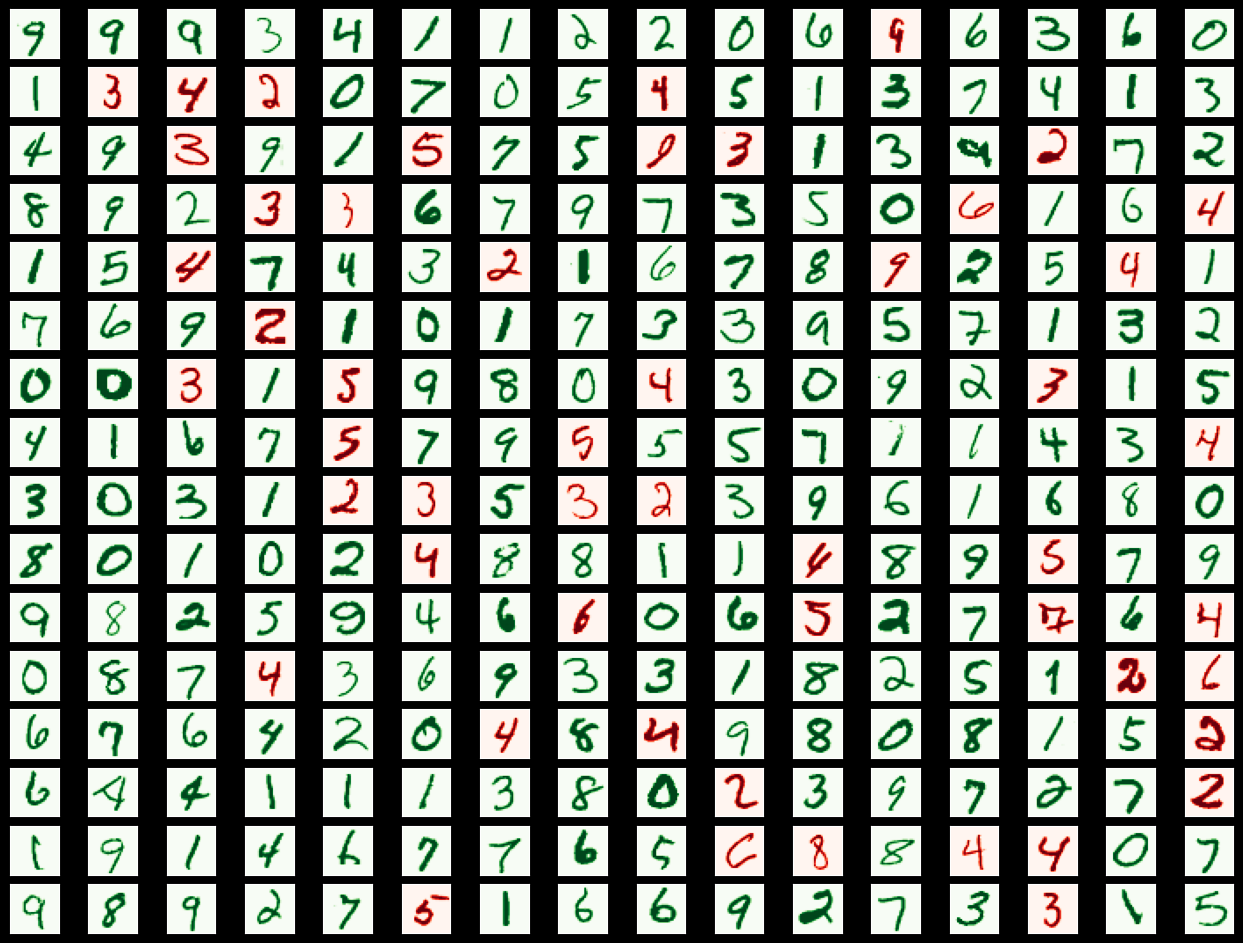

In [57]:
# Check validation set
fig = plt.figure(figsize=(16, 12))
valid_img = X_valid[:256].to(device)
if device.type == 'cuda':
    valid_img = valid_img.cuda()
pred = model(valid_img)
y_pred = torch.argmax(pred, dim=1)
for i in range(256):
    ax = fig.add_subplot(16, 16, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    img = X_valid[i].cpu().numpy().squeeze(0).astype(np.uint8)
    if y_pred[i] == y_valid[i]:
        ax.imshow(img, cmap='Greens')
    else:
        ax.imshow(img, cmap='Reds')
plt.show()

In [60]:
#uploading predication
X_test = torch.from_numpy(df_test.to_numpy().reshape(
    (-1, 1, 28, 28)).astype(np.float32)).to(device)
X_test.shape

torch.Size([28000, 1, 28, 28])

In [61]:
test_ds = MNIST_data(X_test, X_test, DatasetType.TEST, device = device)
test_dl = DataLoader(test_ds, batch_size, shuffle=False, generator = generator)
y_preds = []
model.eval()
with torch.no_grad():
    for idx, (x_batch, y_batch) in enumerate(test_dl):
        print(f"Testing batch: {idx}",end='\r')
        pred = model(x_batch)
        y_hat = torch.argmax(pred, dim=1).tolist()
        y_preds += y_hat

In [62]:
print("Submitting csv...")
output = pd.DataFrame({'Label': y_preds}, index=[i for i in range(1, len(y_preds) + 1)])
output.index.name = 'ImageId'
output.to_csv('submission.csv')
print("Done")

Submitting csv...
Done
